In [70]:
import torch, os, datetime, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms 
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [71]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## Criando uma instância da classe nn.Module para ser nossa rede

Explicando cada parâmetro da camada convolucional:
in_channels => quantos canais de cores os inputs possuem (como é preto e branco, tem apenas um canal)
out_channels => número de filtros (kernels) que será aplicado à imagem (para extrair caracteristicas latentes)
kernel_size => dimensão do filtro (3 é usado comumente pois é o suficiente para pegar detalhes locais mas também percebe padrões maiores)
stride => define o passo que o filtro dá, nesse caso, ele se moverá de pixel em pixel (1) (permite analise mais detalhada da imagem)
padding =>  adiciona pixels em volta da imagem de entrada para assegurar que o tamanho da saída após a convolução permaneça o mesmo que o da entrada. Para um kernel de 3x3 com stride de 1, um padding de 1 mantém o tamanho da imagem inalterado.

In [72]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Definindo a camada convolucional
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Definindo a camada de pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Definindo a camada totalmente conectada (fully connected) de saída
        self.fc1 = nn.Linear(32 * 14 * 14, 10)  # Ajuste de acordo com o tamanho da entrada e o número de classes

    def forward(self, x):
        # Passa pela camada convolucional seguida de uma função de ativação (ReLU)
        x = F.relu(self.conv1(x))
        # Passa pela camada de pooling
        x = self.pool(x)
        # Achata o tensor para passar pela camada totalmente conectada
        x = x.view(-1, 32 * 14 * 14)
        # Passa pela camada totalmente conectada (sem ativação, pois será usada na loss function)
        x = self.fc1(x)
        return x

In [73]:
batch_size = 32

# Transformações para normalizar o dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Carregando o dataset MNIST
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader para o dataset de treinamento e teste
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Conhecendo os dados

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


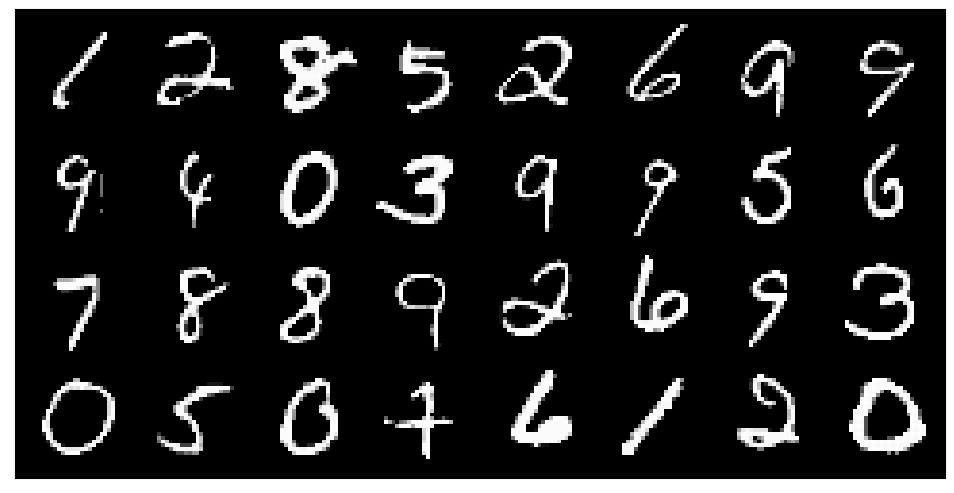

In [74]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(trainloader)

## Instanciando o modelo e criando os parametros

In [75]:
model = SimpleCNN()
learning_rate = 0.001
epochs = 10

# Definindo um critério de perda (loss function) e um otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [76]:
## Função de treinamento e teste do modelo

In [77]:
def train_model(model, trainloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()  # Zera os gradientes
            outputs = model(inputs)  # Passa os inputs pela rede
            loss = criterion(outputs, labels)  # Calcula a perda
            loss.backward()  # Propaga os gradientes
            optimizer.step()  # Atualiza os pesos

            running_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')

def test_model(model, testloader, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%, Test Loss: {test_loss / len(testloader)}')

## Treinando o modelo

In [78]:
train_model(model, trainloader, criterion, optimizer, epochs)

Epoch 1, Loss: 0.37997176980773606
Epoch 2, Loss: 0.17134785991311074
Epoch 3, Loss: 0.12241915351897478
Epoch 4, Loss: 0.09888717361390591
Epoch 5, Loss: 0.08440851065516472
Epoch 6, Loss: 0.0752315792268763
Epoch 7, Loss: 0.06835113021644454
Epoch 8, Loss: 0.0627850466971596
Epoch 9, Loss: 0.05888392187859863
Epoch 10, Loss: 0.05577112354027728


Salvando o modelo após o treinamento

In [79]:
if not os.path.exists('modelos_treinados'):
    os.makedirs('modelos_treinados')

current_datetime = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
path_model_trained = os.path.join('modelos_treinados', f'model_{current_datetime}.pth')

torch.save(model.state_dict(), path_model_trained)

## Testando o modelo

In [80]:
test_model(model, testloader, criterion)

Accuracy: 98.2%, Test Loss: 0.059700112047861104


## Prevendo uma imagem nova

In [81]:
def predict_image(image_path, model):
    # Converte para escala de cinza
    image = Image.open(image_path).convert('L')  
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])
    # Adiciona dimensão de batch (1 imagem)
    image = transform(image).unsqueeze(0) 

    # Passando a imagem pela rede
    output = model(image)

    # Interpretando a saída
    #probabilities = F.softmax(output, dim=1)
    #predicted_class = torch.argmax(probabilities, dim=1).item()  # Obtém a classe com maior probabilidade
    #print('Predicted Class:', predicted_class)
    _, predicted_class = torch.max(output, 1)
    print("Classe prevista:", predicted_class.item())


## Carregando modelo treinado

In [82]:
# path_model_trained = ''

model_trained = SimpleCNN()
model_trained.load_state_dict(torch.load(path_model_trained))
model_trained.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
)

In [83]:
image_path = 'imagens_teste\imagem_teste_4.png'

predict_image(image_path, model_trained)

Classe prevista: 8
